<a href="https://colab.research.google.com/github/qivaijar/oracle-assignment-age-classifier/blob/main/age_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Download AFAD dataset
import os
import tarfile
from tqdm import tqdm

# Download AFAD dataset
dataset_tar = 'afad.tar.xz'
dataset_folder = 'AFAD-Full'

if dataset_folder not in os.listdir():
    !git clone https://github.com/John-niu-07/tarball.git
    !cat tarball/AFAD-Full.tar.xz* > {dataset_tar}
    !rm -rfv tarball
    !tar -xf {dataset_tar}
    !rm {dataset_tar}

# Dataset labelling
afad_filenames = []
afad_ages = []

for age in tqdm(os.listdir(dataset_folder)):
    # Check if folder is not an age value
    if not age.isdigit():
        continue

    sub_folders = os.listdir(
        os.path.join(
            dataset_folder, age
        )
    )

    for sf in sub_folders:
        cur_folder = os.path.join(
            dataset_folder, age, sf
        )

        # Check if file's extension is not .jpg
        for file in os.listdir(cur_folder):
            if not file.endswith('.jpg'):
                continue
            afad_filenames.append(
                os.path.join(
                    cur_folder, file
                )
            )
            afad_ages.append(int(age))


# Create pandas dataframe
import pandas as pd

afad_dataframe = pd.DataFrame(
    {
    'image_path': afad_filenames,
    'age': afad_ages
    }
)

def convert_label(age):
    return 1 if int(age) >= 18 else 0

afad_dataframe['label'] = afad_dataframe['age'].apply(convert_label)

print(afad_dataframe['label'].value_counts())
afad_dataframe

Cloning into 'tarball'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55 (from 1)
Receiving objects: 100% (55/55), 1.43 GiB | 34.02 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (48/48), done.
removed 'tarball/AFAD-Full.tar.xzbn'
removed 'tarball/AFAD-Full.tar.xzaa'
removed 'tarball/AFAD-Full.tar.xzaj'
removed 'tarball/AFAD-Full.tar.xzbp'
removed 'tarball/AFAD-Full.tar.xzad'
removed 'tarball/AFAD-Full.tar.xzal'
removed 'tarball/AFAD-Full.tar.xzah'
removed 'tarball/AFAD-Full.tar.xzbq'
removed 'tarball/AFAD-Full.tar.xzat'
removed 'tarball/.git/description'
removed 'tarball/.git/index'
removed 'tarball/.git/hooks/pre-commit.sample'
removed 'tarball/.git/hooks/post-update.sample'
removed 'tarball/.git/hooks/pre-receive.sample'
removed 'tarball/.git/hooks/pre-applypatch.sample'
removed 'tarball/.git/hooks/update.sample'
removed 'tarball/.git/hooks/push-to-checkout.sample'
removed 'tarball/.git/hooks/commit-msg.sa

100%|██████████| 63/63 [00:00<00:00, 234.90it/s]


label
1    159345
0      6156
Name: count, dtype: int64


,image_path,age,label
0,AFAD-Full/31/112/440025-0.jpg,31,1
1,AFAD-Full/31/112/304032-1.jpg,31,1
2,AFAD-Full/31/112/440443-0.jpg,31,1
3,AFAD-Full/31/112/446117-0.jpg,31,1
4,AFAD-Full/31/112/125520-0.jpg,31,1
...,...,...,...
165496,AFAD-Full/42/111/854992-1.jpg,42,1
165497,AFAD-Full/42/111/860255-0.jpg,42,1
165498,AFAD-Full/42/111/672525-0.jpg,42,1
165499,AFAD-Full/42/111/674946-1.jpg,42,1


In [2]:
## Download UTKFace dataset

# Use this line if this notebook is executed on kaggle
# utkface_folder = "/kaggle/input/utkface-new"

# Use these lines if this notebook is executed on Google Colab
! kaggle datasets download -d jangedoo/utkface-new
! unzip -n utkface-new.zip
utkface_folder = "utkface_aligned_cropped"

# Select dataset's subset (use the cropped images)
selected_subset = 'crop_part1'
utkface_path = os.path.join(utkface_folder, selected_subset)

utk_filenames = []
utk_ages = []

for utkfile in os.listdir(utkface_path):
    # Check if file's extension is not .jpg
    if not utkfile.endswith('.jpg'):
        continue

    # Check race (Asian or not) based on the id
    file_info = utkfile[:-13] # Remove extension (.jpg.chip.jpg)
    file_info = file_info.split('_')
    race_id = file_info[2]
    if int(race_id) == 2: # race id for Asian
        utk_filenames.append(
            os.path.join(
                utkface_path, utkfile
            )
        )
        utk_ages.append(
            int(file_info[0])
        )

utkface_dataframe = pd.DataFrame(
    {
    'image_path': utk_filenames,
    'age': utk_ages
    }
)

utkface_dataframe['label'] = utkface_dataframe['age'].apply(convert_label)

print(utkface_dataframe['label'].value_counts())
utkface_dataframe

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170109140259

,image_path,age,label
0,utkface_aligned_cropped/crop_part1/1_0_2_20161...,1,0
1,utkface_aligned_cropped/crop_part1/1_0_2_20161...,1,0
2,utkface_aligned_cropped/crop_part1/30_1_2_2017...,30,1
3,utkface_aligned_cropped/crop_part1/1_0_2_20161...,1,0
4,utkface_aligned_cropped/crop_part1/53_1_2_2017...,53,1
...,...,...,...
1548,utkface_aligned_cropped/crop_part1/12_0_2_2016...,12,0
1549,utkface_aligned_cropped/crop_part1/72_0_2_2017...,72,1
1550,utkface_aligned_cropped/crop_part1/3_1_2_20161...,3,0
1551,utkface_aligned_cropped/crop_part1/1_0_2_20161...,1,0


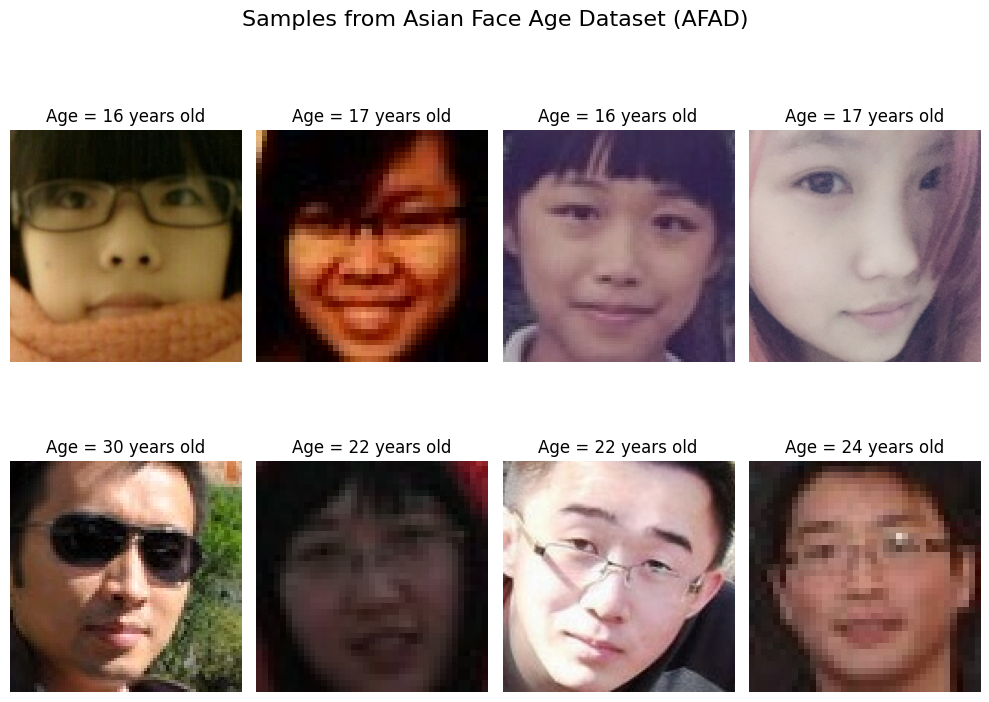

In [85]:
## Show image samples

import matplotlib.pyplot as plt
from PIL import Image

total_images_to_show = 4

# Display samples from AFAD dataset
afad_young_sample = afad_dataframe[afad_dataframe['age'] < 18].sample(n=total_images_to_show)
afad_old_sample = afad_dataframe[afad_dataframe['age'] > 18].sample(n=total_images_to_show)
afad_samples = pd.concat([afad_young_sample, afad_old_sample], ignore_index=True)

# Define grid size
rows, cols = 2, total_images_to_show

fig_afad, axes_afad = plt.subplots(rows, cols, figsize=(10, 8))
axes_afad = axes_afad.ravel()

for i, ax in enumerate(axes_afad):
    ax.imshow(Image.open(afad_samples.iloc[i].image_path))
    ax.set_title(f"Age = {afad_samples.iloc[i].age} years old")
    ax.axis("off")

fig_afad.suptitle('Samples from Asian Face Age Dataset (AFAD)', fontsize=16)
plt.tight_layout()
plt.savefig("samples_afad.png", dpi=300, bbox_inches="tight")
plt.show()

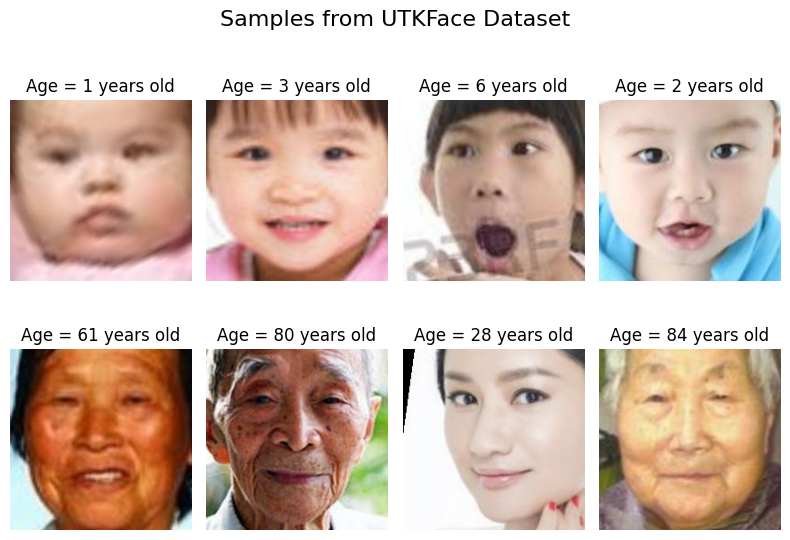

In [86]:
## Display samples from UTKFace dataset

utkface_young_sample = utkface_dataframe[utkface_dataframe['age'] < 18].sample(n=total_images_to_show)
utkface_old_sample = utkface_dataframe[utkface_dataframe['age'] > 18].sample(n=total_images_to_show)
utkface_samples = pd.concat([utkface_young_sample, utkface_old_sample], ignore_index=True)

# Define grid size
rows, cols = 2, total_images_to_show

fig_utkface, axes_utkface = plt.subplots(rows, cols, figsize=(8, 6))
axes_utkface = axes_utkface.ravel()

for i, ax in enumerate(axes_utkface):
    ax.imshow(Image.open(utkface_samples.iloc[i].image_path))
    ax.set_title(f"Age = {utkface_samples.iloc[i].age} years old")
    ax.axis("off")

fig_utkface.suptitle('Samples from UTKFace Dataset', fontsize=16)
plt.tight_layout()
plt.savefig("samples_utkface.png", dpi=300, bbox_inches="tight")
plt.show()

Minimum age = 1,  Mean age = 25.66,  Maximum age = 101
Total samples equal to or over 18 years old = 159920
Total samples under 18 years old = 7134


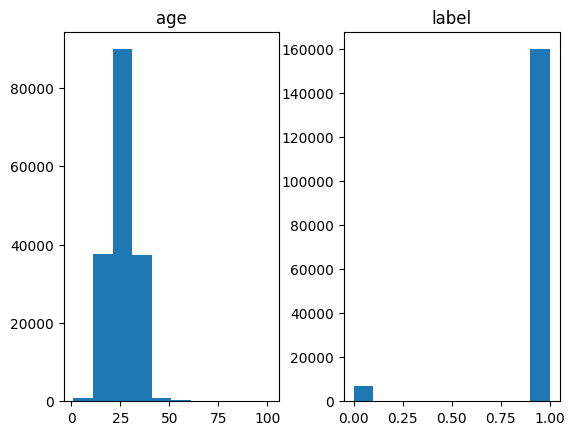

In [5]:
## Combine dataframes

combined_dataframe = pd.concat([afad_dataframe,utkface_dataframe], ignore_index=True)

# Show statistics and histograms
print(f"Minimum age = {combined_dataframe['age'].min()},  Mean age = {combined_dataframe['age'].mean():.2f},  Maximum age = {combined_dataframe['age'].max()}")
print(f"Total samples equal to or over 18 years old = {combined_dataframe['label'].value_counts().get(1)}")
print(f"Total samples under 18 years old = {combined_dataframe['label'].value_counts().get(0)}")

# Create histogram
combined_dataframe.hist(grid=False)

# Get the figure from the Axes object and save it
fig = plt.gcf()
fig.savefig("histogram_before.png", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

Minimum age = 1,  Mean age = 20.26,  Maximum age = 85
Total samples equal to or over 18 years old = 7134
Total samples under 18 years old = 7134


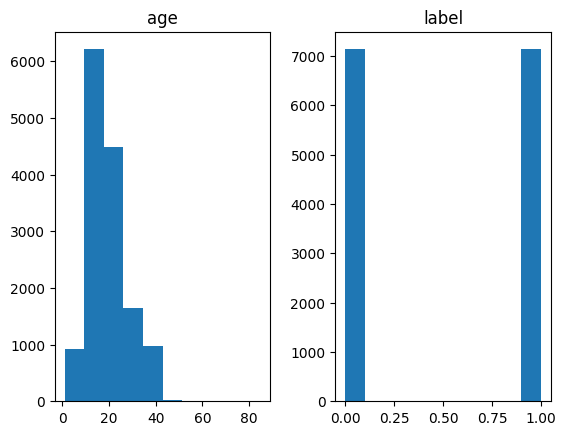

In [6]:
## Perform data resampling

target_sample = combined_dataframe['label'].value_counts().get(0) # resample based on minority class = label 0 or under 18

under18_samples = combined_dataframe[combined_dataframe['label'] == 0].sample(n=target_sample)
over18_samples = combined_dataframe[combined_dataframe['label'] == 1].sample(n=target_sample) # randomly select the samples

resampled_dataframe = pd.concat([under18_samples, over18_samples], ignore_index=True)
resampled_dataframe = resampled_dataframe.sample(frac=1).reset_index(drop=True) # Shuffle the rows, and ignore old index
resampled_dataframe

# Show statistics and histograms
print(f"Minimum age = {resampled_dataframe['age'].min()},  Mean age = {resampled_dataframe['age'].mean():.2f},  Maximum age = {resampled_dataframe['age'].max()}")
print(f"Total samples equal to or over 18 years old = {resampled_dataframe['label'].value_counts().get(1)}")
print(f"Total samples under 18 years old = {resampled_dataframe['label'].value_counts().get(0)}")

# Create histogram
resampled_dataframe.hist(grid=False)

# Get the figure from the Axes object and save it
fig = plt.gcf()
fig.savefig("histogram_after.png", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

In [70]:
## Define parameters

dataloader_kwargs = {
    "batch_size": 8,
    "shuffle": True,
    "drop_last":True,
    "num_workers": 8,
    "pin_memory": True
}

optimizer_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-3
}

lrscheduler_kwargs = {
    "mode": 'min',
    "patience": 2,
    "factor": 0.5
}

augment_ops = 5

In [48]:
# ## Code block for MobileNetV3

# #######################################################
# ########     Define Data Loaders     ##################
# #######################################################

# # Create a PyTorch data loader
# import torch
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from torchvision import models, transforms

# # Create a custom pytorch dataset
# class ImageDataset(Dataset):
#     def __init__(self, dataframe, augment_samples=False, augment_prob=0.75):
#         """
#         Args:
#             dataframe (pd.DataFrame): Pandas DataFrame containing image paths and labels.
#             img_dir (str): Directory where images are stored.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.dataframe = dataframe
#         self.augment_samples = augment_samples
#         self.augment_prob = augment_prob

#         # Get model-specific transform functions
#         weights = models.MobileNet_V3_Large_Weights.DEFAULT
#         self.default_transformation = weights.transforms()

#         # Random image augmentation and then transform the data
#         self.augment_transformation = transforms.Compose([
#             transforms.RandAugment(num_ops=augment_ops),  # Random augmentation
#             self.default_transformation  # Apply default preprocessing transformation (resizing, normalization)
#         ])

#     def __len__(self):
#         """Return the total number of samples in the dataset."""
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         """Fetch a sample (image and label) from the dataset."""
#         img_name = self.dataframe.iloc[idx]['image_path']  # image path column
#         label = self.dataframe.iloc[idx]['label']  # label column

#         # Open the image
#         image = Image.open(img_name).convert("RGB")  # Ensure it's 3-channel

#         # Transform the image
#         if self.augment_samples and (torch.rand(1).item() < self.augment_prob):
#           image = self.augment_transformation(image)
#         else:
#           image = self.default_transformation(image)

#         return image, label


# train_val_df, test_df = train_test_split(resampled_dataframe, test_size=0.1, stratify=resampled_dataframe['label'])
# train_df, val_df = train_test_split(train_val_df, test_size=0.1/0.9, stratify=train_val_df['label'])

# train_dataset = ImageDataset(train_df, augment_samples=True)
# val_dataset = ImageDataset(val_df)
# test_dataset = ImageDataset(test_df)

# train_loader = DataLoader(train_dataset, **dataloader_kwargs)
# val_loader = DataLoader(val_dataset, **dataloader_kwargs)
# test_loader = DataLoader(test_dataset, **dataloader_kwargs)

# # Check total training and testing dataset
# print(f"Total samples for model training = {len(train_dataset)}")
# print(f"Total samples for model validation = {len(val_dataset)}")
# print(f"Total samples for model evaluation = {len(test_dataset)}")

##############################################################
#######    Model Definition     ##############################
##############################################################

# import torch
# import torch.nn as nn
# from torchvision import models
# import torch.optim as optim

# class AgeClassifier(nn.Module):
#     def __init__(self):
#         super(AgeClassifier, self).__init__()
#         self.model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

#         self.model.classifier = nn.Sequential(
#             nn.Linear(self.model.classifier[0].in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

# model = AgeClassifier()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.BCELoss()
# optimizer = optim.AdamW(model.parameters(), **optimizer_kwargs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **lrscheduler_kwargs)

Total samples for model training = 11414
Total samples for model validation = 1427
Total samples for model evaluation = 1427


In [62]:
# ## Code block for EffcientNetV2

# ################################################
# ########     Define Data Loaders     ###########
# ################################################

# # Create a PyTorch data loader
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from torchvision import models, transforms

# # Create a custom pytorch dataset
# class ImageDataset(Dataset):
#     def __init__(self, dataframe, augment_samples=False, augment_prob=0.75):
#         """
#         Args:
#             dataframe (pd.DataFrame): Pandas DataFrame containing image paths and labels.
#             img_dir (str): Directory where images are stored.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.dataframe = dataframe
#         self.augment_samples = augment_samples
#         self.augment_prob = augment_prob

#         # Get model-specific transform functions
#         weights = models.EfficientNet_V2_L_Weights.DEFAULT
#         self.default_transformation = weights.transforms()

#         # Random image augmentation and then transform the data
#         self.augment_transformation = transforms.Compose([
#             transforms.RandAugment(num_ops=augment_ops),  # Random augmentation
#             self.default_transformation  # Apply default preprocessing transformation (resizing, normalization)
#         ])

#     def __len__(self):
#         """Return the total number of samples in the dataset."""
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         """Fetch a sample (image and label) from the dataset."""
#         img_name = self.dataframe.iloc[idx]['image_path']  # image path column
#         label = self.dataframe.iloc[idx]['label']  # label column

#         # Open the image
#         image = Image.open(img_name).convert("RGB")  # Ensure it's 3-channel

#         # Transform the image
#         if self.augment_samples and (torch.rand(1).item() < self.augment_prob):
#           image = self.augment_transformation(image)
#         else:
#           image = self.default_transformation(image)

#         return image, label


# train_val_df, test_df = train_test_split(resampled_dataframe, test_size=0.1, stratify=resampled_dataframe['label'])
# train_df, val_df = train_test_split(train_val_df, test_size=0.1/0.9, stratify=train_val_df['label'])

# train_dataset = ImageDataset(train_df, augment_samples=True)
# val_dataset = ImageDataset(val_df)
# test_dataset = ImageDataset(test_df)

# train_loader = DataLoader(train_dataset, **dataloader_kwargs)
# val_loader = DataLoader(val_dataset, **dataloader_kwargs)
# test_loader = DataLoader(test_dataset, **dataloader_kwargs)

# # Check total training and testing dataset
# print(f"Total samples for model training = {len(train_dataset)}")
# print(f"Total samples for model validation = {len(val_dataset)}")
# print(f"Total samples for model evaluation = {len(test_dataset)}")


# ##############################################################
# #######    Model Definition     ##############################
# ##############################################################

# import torch
# import torch.nn as nn
# from torchvision import models
# import torch.optim as optim

# class AgeClassifier(nn.Module):
#     def __init__(self):
#         super(AgeClassifier, self).__init__()
#         self.model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)

#         # Correctly replace the classifier layer
#         in_features = self.model.classifier[1].in_features
#         self.model.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 1),
#             nn.Sigmoid()  # Ensure BCELoss is correctly used
#         )

#     def forward(self, x):
#         return self.model(x)

# model = AgeClassifier()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.BCELoss()
# optimizer = optim.AdamW(model.parameters(),**optimizer_kwargs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **lrscheduler_kwargs)

Total samples for model training = 11414
Total samples for model validation = 1427
Total samples for model evaluation = 1427


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 174MB/s]


In [80]:
## Code block for SqueezeNet

################################################
########     Define Data Loaders     ###########
################################################

# Create a PyTorch data loader
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

# Create a custom pytorch dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, augment_samples=False, augment_prob=0.75):
        """
        Args:
            dataframe (pd.DataFrame): Pandas DataFrame containing image paths and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.augment_samples = augment_samples
        self.augment_prob = augment_prob

        # Get model-specific transform functions
        weights = models.SqueezeNet1_1_Weights.DEFAULT
        self.default_transformation = weights.transforms()

        # Random image augmentation and then transform the data
        self.augment_transformation = transforms.Compose([
            transforms.RandAugment(num_ops=augment_ops),  # Random augmentation
            self.default_transformation  # Apply default preprocessing transformation (resizing, normalization)
        ])

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetch a sample (image and label) from the dataset."""
        img_name = self.dataframe.iloc[idx]['image_path']  # image path column
        label = self.dataframe.iloc[idx]['label']  # label column

        # Open the image
        image = Image.open(img_name).convert("RGB")  # Ensure it's 3-channel

        # Transform the image
        if self.augment_samples and (torch.rand(1).item() < self.augment_prob):
          image = self.augment_transformation(image)
        else:
          image = self.default_transformation(image)

        return image, label


train_val_df, test_df = train_test_split(resampled_dataframe, test_size=0.1, stratify=resampled_dataframe['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.1/0.9, stratify=train_val_df['label'])

train_dataset = ImageDataset(train_df, augment_samples=True)
val_dataset = ImageDataset(val_df)
test_dataset = ImageDataset(test_df)

train_loader = DataLoader(train_dataset, **dataloader_kwargs)
val_loader = DataLoader(val_dataset, **dataloader_kwargs)
test_loader = DataLoader(test_dataset, **dataloader_kwargs)

# Check total training and testing dataset
print(f"Total samples for model training = {len(train_dataset)}")
print(f"Total samples for model validation = {len(val_dataset)}")
print(f"Total samples for model evaluation = {len(test_dataset)}")


##############################################################
#######    Model Definition     ##############################
##############################################################

import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

class AgeClassifier(nn.Module):
    def __init__(self):
        super(AgeClassifier, self).__init__()
        self.model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)

        # Get the number of input features from the last conv layer
        in_features = self.model.classifier[1].in_channels  # Get input channels of last conv layer

        # Replace the classifier with a new sequential block
        self.model.classifier = nn.Sequential(
            nn.Conv2d(in_features, 512, kernel_size=1),  # Adjust last conv layer
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Global average pooling to make it a 1x1 output
            nn.Flatten(),
            nn.Linear(512, 1),  # Binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = AgeClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(),**optimizer_kwargs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **lrscheduler_kwargs)

Total samples for model training = 11414
Total samples for model validation = 1427
Total samples for model evaluation = 1427


In [81]:
## Training Loop

import time

num_epochs = 15
verbose_steps = 200
step = 0
val_los = float('inf')
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []


start_time = time.time()
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        # Move data to the specified device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print running loss every verbose_steps
        running_loss += loss.item()
        step += 1
        if (step + 1) % verbose_steps == 0:
            print(f"Current loss: {loss.item()}")

        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    training_loss.append(epoch_loss)
    training_accuracy.append(epoch_accuracy)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / len(val_loader)
    scheduler.step(val_epoch_loss)
    val_epoch_accuracy = val_correct / val_total * 100
    validation_loss.append(val_epoch_loss)
    validation_accuracy.append(val_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

    # Save checkpoint for the best val los
    if val_epoch_loss < val_los:
      val_los = val_epoch_loss
      checkpoint_path = f"checkpoint_best_val_los.pth"
      checkpoint = {
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': epoch_loss,
          'accuracy': epoch_accuracy,
          'val_loss': val_epoch_loss,
          'val_accuracy': val_epoch_accuracy
      }
      torch.save(checkpoint, checkpoint_path)
      print(f"Checkpoint saved at: {checkpoint_path}")

# Save the last checkpoint
checkpoint_path = f"checkpoint_last.pth"
checkpoint = {
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,
    'accuracy': epoch_accuracy,
    'val_loss': val_epoch_loss,
    'val_accuracy': val_epoch_accuracy
}
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved at: {checkpoint_path}")
# End time
end_time = time.time()

# Calculate training time
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.4f} seconds")

Current loss: 0.7123668193817139
Current loss: 0.5674753189086914
Current loss: 0.6682770252227783
Current loss: 0.6397415995597839
Current loss: 0.6893478631973267
Current loss: 0.49954238533973694
Current loss: 0.5196490287780762
Epoch [1/15], Train Loss: 0.6317, Train Accuracy: 65.20%, Val Loss: 0.6158, Val Accuracy: 68.54%
Checkpoint saved at: checkpoint_best_val_los.pth
Current loss: 0.7186586856842041
Current loss: 0.7268213629722595
Current loss: 0.6657946109771729
Current loss: 0.6940742135047913
Current loss: 0.6074537038803101
Current loss: 0.5792731046676636
Current loss: 0.7838201522827148
Epoch [2/15], Train Loss: 0.5956, Train Accuracy: 68.84%, Val Loss: 0.5651, Val Accuracy: 71.14%
Checkpoint saved at: checkpoint_best_val_los.pth
Current loss: 0.6965665221214294
Current loss: 0.7092894315719604
Current loss: 0.619304358959198
Current loss: 0.3448749780654907
Current loss: 0.4477487802505493
Current loss: 0.6955753564834595
Current loss: 0.591413140296936
Epoch [3/15], Tr

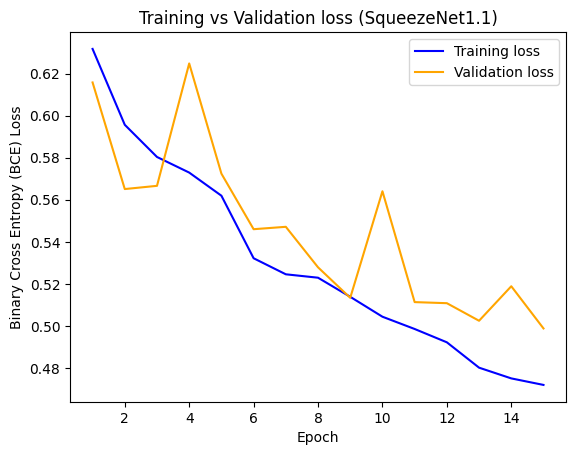

In [83]:
## Plot training and validation loss

total_epoch = len(training_loss)
epoch = list(range(1, total_epoch+1))

# Plot the training loss
plt.plot(epoch, training_loss, label='Training loss', color='blue')  # Red line

# Plot the validation loss
plt.plot(epoch, validation_loss, label='Validation loss', color='orange')  # Green line

# Adding labels
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy (BCE) Loss')
plt.title('Training vs Validation loss (SqueezeNet1.1)')

# Show legend
plt.legend()

# Save the plot
plt.savefig("train_val_loss.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


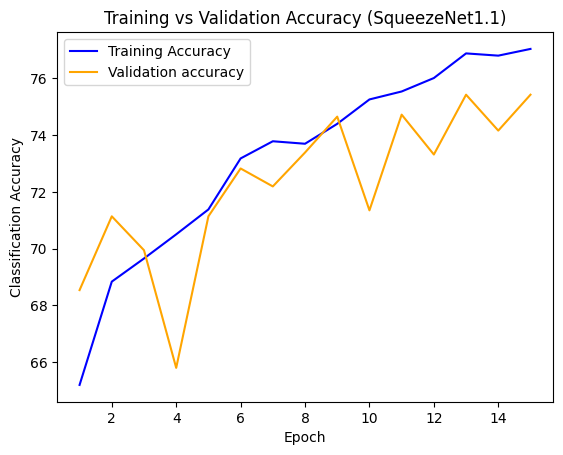

In [84]:
## Plot the training accuracy

plt.plot(epoch, training_accuracy, label='Training Accuracy', color='blue')  # Red line

# Plot the validation accuracy
plt.plot(epoch, validation_accuracy, label='Validation accuracy', color='orange')  # Green line


# Adding labels
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.title('Training vs Validation Accuracy (SqueezeNet1.1)')

# Show legend
plt.legend()

# Save the plot
plt.savefig("train_val_acc.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [88]:
## Perform model evaluation on testing data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load model based on check point

checkpoint_path = "checkpoint_best_val_los.pth"
# checkpoint_path = "checkpoint_last.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

# Initialize lists to store true labels and predictions
all_labels = []
all_preds = []

# If you're using a loss function (e.g., for binary classification)
criterion = torch.nn.BCEWithLogitsLoss()  # Example for binary classification, modify if needed

# Iterate over the test dataloader
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # Forward pass

        # Calculate loss (if applicable)
        loss = criterion(outputs.squeeze(), labels.float())  # Assuming binary classification

        # Convert model outputs to predictions
        preds = (outputs > 0.5).float()  # Assuming binary classification

        # Collect labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())  # Convert to numpy for sklearn
        all_preds.extend(preds.squeeze().cpu().numpy())  # Convert to numpy for sklearn

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

<ipython-input-88-6102a8a142a9>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Accuracy: 0.7395
Precision: 0.7701
Recall: 0.6849
F1-Score: 0.7250


In [ ]:
# Save the model
torch.save(model, 'SqueezeNet1.1.pth')